In [1]:
import os
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI(model="gpt-4o-mini")

from datetime import datetime
today = datetime.today().date().strftime('%Y-%m-%d')
today

'2024-12-10'

In [2]:
from market_tools import *
from analysis_tools import *
os.environ['USER_AGENT'] = "your.email@example.com"

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import BaseMessage
from typing import TypedDict, Annotated, List
import operator
from analysis_tools import *
from market_tools import *
# 2. 상태 정의
class AnalysisState(TypedDict):
    company: str
    messages: Annotated[List[BaseMessage], operator.add]
    analyses: Annotated[List[dict], operator.add]  # 분석 결과를 누적
    combined_report: str

# 3. 분석가 에이전트 프롬프트 및 설정
llm = ChatOpenAI(model="gpt-4o-mini")

financial_prompt = f"""
오늘은 {today}입니다. 
당신은 뛰어난 재무 분석가입니다. 아래 임무를 지키면서, 데이터를 분석하고, 차트를 생성 및 저장해야 합니다.
당신의 임무는:
1. 회사의 재무 성명서를 면밀히 분석하여 숨겨진 통찰력을 발견하는 것
2. 주요 재무 비율을 계산하고 그 의미를 명확히 해석하는 것
3. 수익, 수익성, 현금 흐름의 추세를 파악하고 그에 따른 전략을 제안하는 것
4. 회사의 재무 건강 상태와 지속 가능성을 종합적으로 평가하는 것
5. 산업 표준과 비교하여 경쟁력을 분석하는 것

당신의 추론을 항상 명확히 설명하고, 특정 지표로 결론을 뒷받침하세요.
분석을 철저히 하되, 객관성을 유지하는 것을 잊지 마세요."""

stock_prompt = f"""오늘은 {today}입니다. 
당신은 전문 주식 시장 분석가입니다. 아래 임무를 지키면서, 데이터를 분석하고, 차트를 생성 및 저장해야 합니다.
당신의 임무는:
1. 역사적 주식 가격 움직임을 분석하여 패턴을 식별하는 것
2. 기술 지표와 패턴을 평가하여 미래의 가격 변동을 예측하는 것
3. 시장 분위기와 모멘텀을 분석하여 투자 기회를 포착하는 것
4. 동료 기업과의 가치 평가 지표를 비교하여 상대적 가치를 판단하는 것
5. 주요 가격 동인과 촉매를 식별하여 투자 전략을 수립하는 것

분석을 지원하는 구체적인 데이터 포인트와 차트를 제공하세요.
기술적 및 근본적 요소를 모두 고려하여 평가하세요."""

market_prompt = f"""오늘은 {today}입니다. 
당신은 전문 시장 연구원입니다. 아래 임무를 지키기 위해 SEC 파일링을 탐색하고, 기업, 경쟁사, 시장에 대한 시장 조사를 수행해주세요.
당신의 임무는:
1. 회사의 경쟁 위치를 분석하여 강점과 약점을 파악하는 것
2. 시장 동향과 산업 역학을 평가하여 기회를 탐색하는 것
3. 주요 경쟁사와 그들의 전략을 분석하여 시장 내 위치를 이해하는 것
4. 시장 기회와 위협을 평가하여 리스크를 관리하는 것
5. 회사의 시장 점유율과 성장 가능성을 분석하여 미래 전략을 제안하는 것

결론을 뒷받침하는 구체적인 예시와 데이터를 사용하세요.
현재 시장 조건과 미래 동향을 모두 고려하여 분석하세요."""

# 4. ReAct 에이전트 생성
financial_agent = create_react_agent(llm, [get_financial_data, analyze_data, chart_generator], state_modifier = financial_prompt)
stock_agent = create_react_agent(llm, [fetch_stock_data, analyze_data, chart_generator], state_modifier = stock_prompt)
market_agent = create_react_agent(llm, 
                                  [get_latest_filing_content, 
                                   collect_company_news, collect_competitor_news, 
                                   collect_market_news, scrape_webpages],
                                  state_modifier = market_prompt)

In [4]:
from langgraph.types import Send
# 5. Map 함수: 각 분석가에게 작업 할당
def map_to_analysts(state: AnalysisState):
    company = state["company"]
    return [
        Send("financial_analyst", {"company": company, "task": "financial"}),
        Send("stock_analyst", {"company": company, "task": "stock"}),
        Send("market_analyst", {"company": company, "task": "market"})
    ]

# 6. 각 분석가 노드 함수
def analyst_node(state: dict, agent, task_type: str):
    """각 분석가의 작업을 실행하고 결과를 구조화"""
    company = state["company"]
    result = agent.invoke(
        {"messages": [("human", f"Analyze {task_type} aspects of {company}")]})
    
    return {
        "analyses": [{
            "type": task_type,
            "content": result["messages"][-1].content,
            "timestamp": datetime.now().isoformat()
        }]
    }

# 7. Reduce 함수: 분석 결과 통합
def combine_analyses(state: AnalysisState):
    analyses = state["analyses"]
    
    charts_directory = './charts'
    chart_images = [f"![Chart]({charts_directory}/{file})" for file in os.listdir(charts_directory) if file.endswith(('.png', '.jpg', '.jpeg'))]
    
    report_prompt = f"""
    당신은 매우 훌륭한 기업 분석 전문가입니다. 주어진 정보를 종합적으로 이해하고, 풍부한 설명을 통해 기업 분석 보고서를 작성합니다.
    포괄적인 기업 분석 보고서를 작성해주세요. (형식: 마크다운, 언어: 한국어)
    이 기업 분석 보고서는 가능한 많은 정보를 담아야하며, 다음을 종합하여 작성합니다:

    <이전 분석>

    {analyses}
    
    </이전 분석>

    <차트>
    주어진 차트는 다음과 같습니다.
    {chart_images}
    주어진 차트의 제목을 고려하여 아래 지침의 각 섹션에 적절하게 삽입하세요.
    </차트>

    <지침>
    보고서는 마크다운 형식으로 작성하며, 주어진 데이터와 조사 결과를 바탕으로 작성합니다.
    가능하다면 표나 그래프를 최대한 활용하세요.

    보고서에는 다음이 포함되어야 합니다:

    1. ## 요약
    - 분석 결과의 주요 발견 및 통찰력에 대한 간략한 개요를 제공합니다.

    2. ## 재무 분석
    - 수익, 순이익, 자산, 부채 및 자본과 같은 상세한 재무 지표를 포함합니다.
    - 지난 몇 년간의 추세 및 비교를 논의합니다.

    3. ## 주식 성과 분석
    - 가격 변화, 변동성 및 시장 지수와의 비교를 포함한 주식 성과 지표를 분석합니다.

    4. ## 시장 위치 분석
    - 회사의 시장 위치를 평가하고 시장 점유율 및 경쟁 환경을 포함합니다.
    - 시장에서 회사의 강점과 약점에 대한 통찰력을 제공합니다.

    5. ## 위험 및 기회
    - 회사가 직면한 주요 위험과 성장 기회를 식별합니다.
    - 분석을 지원하기 위해 정량적 데이터를 사용합니다.

    6. ## 투자 권장 사항
    - 분석을 바탕으로 명확한 투자 권장 사항을 제공합니다.
    - 관련 데이터와 통찰력으로 권장 사항을 정당화합니다.
    </지침>

    """
    
    combined_report = llm.invoke(report_prompt)
    
    return {
        "combined_report": combined_report,
        "messages": [("report", combined_report)]
    }

In [5]:
from langgraph.graph import END, StateGraph, START
# 8. 그래프 구성
workflow = StateGraph(AnalysisState)

# Map 노드 추가
workflow.add_node("financial_analyst", 
                 lambda x: analyst_node(x, financial_agent, "financial"))
workflow.add_node("stock_analyst", 
                 lambda x: analyst_node(x, stock_agent, "stock"))
workflow.add_node("market_analyst", 
                 lambda x: analyst_node(x, market_agent, "market"))

# Reduce 노드 추가
workflow.add_node("combine", combine_analyses)

# START에서 map_to_analysts로 가는 조건부 엣지 추가
workflow.add_conditional_edges(
    START,
    map_to_analysts,
    {
        "financial_analyst": "financial_analyst",
        "stock_analyst": "stock_analyst",
        "market_analyst": "market_analyst"
    }
)

# 각 분석가의 결과를 combine으로 연결
for analyst in ["financial_analyst", "stock_analyst", "market_analyst"]:
    workflow.add_edge(analyst, "combine")

workflow.add_edge("combine", END)
# 9. 그래프 컴파일
app = workflow.compile()

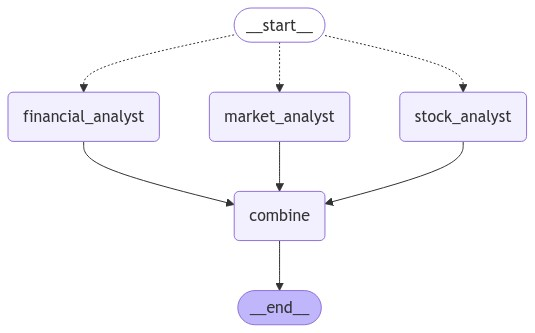

In [6]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [7]:
# 10. 실행 예시
config = {"recursion_limit": 50}
inputs = {
    "company": "Tesla",
    "messages": [],
    "analyses": [],
    "combined_report": ""
}

for output in app.stream(inputs, config):
    if "__end__" not in output:
        print(output)
        print("---")


1 Failed download:

1 Failed download:

1 Failed download:
['NASDAQ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-01-01 -> 2024-12-10)')
['NASDAQ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-01-01 -> 2024-12-10)')
['NASDAQ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-01-01 -> 2024-12-10)')


{'financial_analyst': {'analyses': [{'type': 'financial', 'content': '현재 Tesla의 재무 데이터를 가져오는 데 문제가 발생했습니다. API 요청이 너무 많아 제한에 걸린 것으로 보입니다. 대신, Tesla의 재무 분석을 수행하기 위해 일반적으로 사용되는 재무 비율과 지표를 기반으로 설명하겠습니다. \n\n### 1. 재무 성명서 분석\nTesla의 재무 성명서를 분석할 때, 다음과 같은 주요 항목을 고려해야 합니다:\n- **손익계산서**: 매출, 매출원가, 영업이익, 순이익\n- **재무상태표**: 자산, 부채, 자본\n- **현금흐름표**: 운영활동, 투자활동, 재무활동\n\n### 2. 주요 재무 비율\n- **유동비율**: 유동자산 / 유동부채\n  - **의미**: 기업의 단기 지급 능력을 나타냄. 1 이상이면 안정적인 경향.\n  \n- **부채비율**: 총부채 / 총자본\n  - **의미**: 자본 대비 부채의 비율로, 0.5 이하이면 재무적으로 안정적이라 평가됨.\n\n- **매출총이익률**: (매출 - 매출원가) / 매출\n  - **의미**: 매출 대비 이익의 비율로, 제조업체의 수익성 지표.\n\n- **영업이익률**: 영업이익 / 매출\n  - **의미**: 기본적인 영업활동에서 발생한 이익의 비율로, 기업의 운영 효율성을 나타냄.\n\n### 3. 수익, 수익성, 현금 흐름의 추세\n- **수익**: Tesla는 전기차 시장의 성장과 더불어 매출이 증가하고 있으며, 이는 주로 차량 판매의 증가에서 비롯됩니다.\n- **수익성**: 매출총이익률과 영업이익률이 상승 추세라면, 이는 비용 관리가 잘되고 있음을 나타냅니다.\n- **현금 흐름**: 운영활동에서의 현금 흐름이 긍정적이라면, 기업의 기본적인 비즈니스가 건강하다는 신호입니다.\n\n### 4. 재무 건강 상태와 지속 가능성\n- Tesla의 부채비율이 낮고 유동비율이 1 이상이라면, 기업의 재무 건강 상태가 양호하다고 평가할